# Monitoring Optimisation

In this notebook we cover how to monitor the model and certain metrics during optimisation.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import gpflow
from gpflow.ci_utils import ci_niter

np.random.seed(0)

The monitoring functionality lives in `gpflow.monitor`.
For now, we import `ModelToTensorBoard`, `ImageToTensorBoard`, `ScalarToTensorBoard` monitoring tasks and `MonitorTaskGroup` and `Monitor`.

In [2]:
from gpflow.monitor import (
    ImageToTensorBoard,
    ModelToTensorBoard,
    Monitor,
    MonitorTaskGroup,
    ScalarToTensorBoard,
)

## Set up data and model

In [3]:
# Define some configuration constants.

num_data = 100
noise_std = 0.1
optimisation_steps = ci_niter(100)

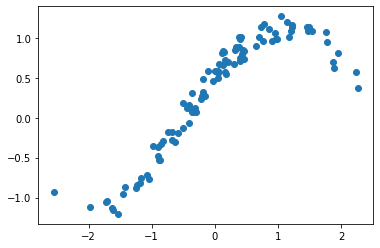

In [4]:
# Create dummy data.

X = np.random.randn(num_data, 1)  # [N, 2]
Y = np.sin(X) + 0.5 * np.cos(X) + np.random.randn(*X.shape) * noise_std  # [N, 1]
plt.plot(X, Y, "o")

In [5]:
# Set up model and print

kernel = gpflow.kernels.SquaredExponential(lengthscales=[1.0, 2.0]) + gpflow.kernels.Linear()
model = gpflow.models.GPR((X, Y), kernel, noise_variance=noise_std ** 2)
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1. 2.]
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01000000000000004


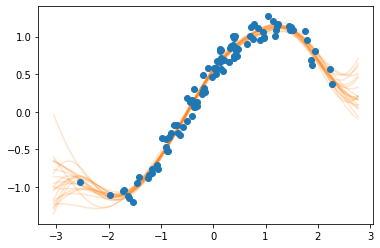

In [6]:
# We define a function that plots the model's prediction (in the form of samples) together with the data.
# Importantly, this function has no other argument than `fig: matplotlib.figure.Figure` and `ax: matplotlib.figure.Axes`.


def plot_prediction(fig, ax):
    Xnew = np.linspace(X.min() - 0.5, X.max() + 0.5, 100).reshape(-1, 1)
    Ypred = model.predict_f_samples(Xnew, full_cov=True, num_samples=20)
    ax.plot(Xnew.flatten(), np.squeeze(Ypred).T, "C1", alpha=0.2)
    ax.plot(X, Y, "o")


# Let's check if the function does the desired plotting
fig = plt.figure()
ax = fig.subplots()
plot_prediction(fig, ax)
plt.show()

## Set up monitoring tasks

We now define the `MonitorTask`s that will be executed during the optimisation.
For this tutorial we set up three tasks:
- `ModelToTensorBoard`: writes the models hyper-parameters such as `likelihood.variance` and `kernel.lengthscales` to a TensorBoard.
- `ImageToTensorBoard`: writes custom matplotlib images to a TensorBoard.
- `ScalarToTensorBoard`: writes any scalar value to a TensorBoard. Here, we use it to write the model's training objective.

In [7]:
log_dir = "logs"  # Directory where TensorBoard files will be written.
model_task = ModelToTensorBoard(log_dir, model)
image_task = ImageToTensorBoard(log_dir, plot_prediction, "image_samples")
lml_task = ScalarToTensorBoard(log_dir, lambda: model.training_loss(), "training_objective")

We now group the tasks in a set of fast and slow tasks and pass them to the monitor.
This allows us to execute the groups at a different frequency.

In [8]:
# Plotting tasks can be quite slow. We want to run them less frequently.
# We group them in a `MonitorTaskGroup` and set the period to 5.
slow_tasks = MonitorTaskGroup(image_task, period=5)

# The other tasks are fast. We run them at each iteration of the optimisation.
fast_tasks = MonitorTaskGroup([model_task, lml_task], period=1)

# Both groups are passed to the monitor.
# `slow_tasks` will be run five times less frequently than `fast_tasks`.
monitor = Monitor(fast_tasks, slow_tasks)

In [9]:
training_loss = model.training_loss_closure(
    compile=True
)  # compile=True (default): compiles using tf.function
opt = tf.optimizers.Adam()

for step in range(optimisation_steps):
    opt.minimize(training_loss, model.trainable_variables)
    monitor(step)  # <-- run the monitoring

TensorBoard is accessible through the browser, after launching the server by running `tensorboard --logdir ${logdir}`.
See the [TensorFlow documentation on TensorBoard](https://www.tensorflow.org/tensorboard/get_started) for more information.

For optimal performance, we can also wrap the monitor call inside `tf.function`:

In [10]:
opt = tf.optimizers.Adam()

log_dir = f"{log_dir}/compiled"
model_task = ModelToTensorBoard(log_dir, model)
lml_task = ScalarToTensorBoard(log_dir, lambda: model.training_loss(), "training_objective")
# Note that the `ImageToTensorBoard` task cannot be compiled, and is omitted from the monitoring
monitor = Monitor(MonitorTaskGroup([model_task, lml_task]))

In the optimisation loop below we use `tf.range` (rather than Python's built-in range) to avoid re-tracing the `step` function each time.

In [11]:
@tf.function
def step(i):
    opt.minimize(model.training_loss, model.trainable_variables)
    monitor(i)


# Notice the tf.range
for i in tf.range(optimisation_steps):
    step(i)

When opening TensorBoard, you may need to use the command `tensorboard --logdir . --reload_multifile=true`, as multiple `FileWriter` objects are used.